In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import re
import string
import emoji

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
from google.colab import drive

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv(r'/content/drive/MyDrive/corona_sentiment/Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv(r'/content/drive/MyDrive/corona_sentiment/Corona_NLP_test.csv',encoding='latin1')

In [5]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Cleaning 🧩

In [15]:
nltk.download('stopwords')
nltk.download('punkt')

stop_word = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
import re

def clean(text):
    # remove urls
    text = re.sub(r'http\S+', " ", text)

    # remove mentions
    text = re.sub(r'@\w+', ' ', text)

    # remove hashtags
    text = re.sub(r'#\w+', ' ', text)

    # remove digits
    text = re.sub(r'\d+', ' ', text)

    # remove html tags
    text = re.sub('<.*?>', ' ', text)

    # remove emojis
    emoji_pattern = re.compile("["
            u"\U0001F300-\U0001F5FF"  # symbol maps&country
            u"\U0001F680-\U0001F6FF"  # time & vehicle symbol
            u"\U0001F780-\U0001F7FF"  # kartu & simbol bermain
            u"\U0001F900-\U0001F9FF"  # face emoji 
            u"\U0001FA00-\U0001FA6F"  # sport emoji 
            u"\U0001FA70-\U0001FAFF"  # food emoji 
            "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    #Removal of Punctuation Marks
    def remove_punctuations(text):
        return re.sub('\[[^]]*\]', '', text)

    # Removal of Special Characters
    def remove_characters(text):
        return re.sub("[^a-zA-Z]"," ",text)

    # remove stop words
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])

    return text

In [17]:
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: clean(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: clean(x))

In [20]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,,Neutral
1,3800,48752,UK,2020-03-16,advice Talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths give elderly...,Positive
3,3802,48754,NaN,2020-03-16,"My food stock one empty... PLEASE, panic, THER...",Positive
4,3803,48755,NaN,2020-03-16,"Me, ready go supermarket outbreak. Not I'm par...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering stock supermarket shel...,Neutral
41153,44952,89904,NaN,2020-04-14,Response complaint provided citing COVID- rela...,Extremely Negative
41154,44953,89905,NaN,2020-04-14,You know itÂs getting tough rationing toilet ...,Positive
41155,44954,89906,NaN,2020-04-14,Is wrong smell hand sanitizer starting turn on?,Neutral


In [21]:
X = train['OriginalTweet']
y = train['Sentiment']

In [22]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']


y.replace(encoding, inplace=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32925,), (8232,), (32925,), (8232,))

# Tokenizing

In [24]:
%pip install spacy

In [25]:
!python -m spacy download en_core_web_sm

2023-12-18 00:06:09.114764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 00:06:09.114817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 00:06:09.116156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 00:06:09.123253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 00:06:10.131325: W tensorflow/compiler/tf2

In [26]:
import tensorflow as tf
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nlp = spacy.load("en_core_web_sm")

In [27]:
# Make function to tokenize the text with spacy
def tokenize_with_spacy(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [28]:
# Tokenize for X_train
X_train_tokenized = [tokenize_with_spacy(text) for text in X_train]

# Tokenize for X_test
X_test_tokenized = [tokenize_with_spacy(text) for text in X_test]

In [29]:
# Given one sample index after tokenizing phase 
sample_index = 0
print("Tokenized Text:", X_train_tokenized[sample_index])

Tokenized Text: ['Unemployment', 'claims', 'made', 'online', 'Virginia', 'week', ':', 'Monday', ':', 'Tuesday', ':', ',', 'And', 'numbers', 'going', 'get', 'bigger', '.']


In [30]:
# Mixing token from train and test
all_tokens = X_train_tokenized + X_test_tokenized

# Build tokenizer and convert to indexs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tokens)

In [31]:
X_train_indexed = tokenizer.texts_to_sequences(X_train_tokenized)
X_test_indexed = tokenizer.texts_to_sequences(X_test_tokenized)

In [32]:
# Padding for X_train
X_train_padded = pad_sequences(X_train_indexed, maxlen=300, padding='post', truncating='post')

# Padding for X_test
X_test_padded = pad_sequences(X_test_indexed, maxlen=300, padding='post', truncating='post')

In [34]:
y_test.value_counts()

2    3617
0    3062
1    1553
Name: Sentiment, dtype: int64

In [35]:
X_train_padded

array([[ 959, 1320,  269, ...,    0,    0,    0],
       [  30,    7,   51, ...,    0,    0,    0],
       [ 560,    7, 6788, ...,    0,    0,    0],
       ...,
       [ 164, 9955,   12, ...,    0,    0,    0],
       [ 123, 1123,  146, ...,    0,    0,    0],
       [1578, 9659,    0, ...,    0,    0,    0]], dtype=int32)

# Build Model

In [36]:
import tensorflow.keras.layers as L

In [37]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

36543

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define filename for best model
checkpoint_filepath = 'best_lstm_model.h5'

# Build model checkpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Build model checkpoint earlystopping
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  
    restore_best_weights=True,  
    verbose=1
)

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=300),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')  
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

# Evaluating Model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Epoch 1/20
824/824 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.7098
Epoch 1: val_accuracy improved from -inf to 0.84617, saving model to best_lstm_model.h5
824/824 [==============================] - 40s 44ms/step - loss: 0.6818 - accuracy: 0.7098 - val_loss: 0.4400 - val_accuracy: 0.8462
Epoch 2/20
  1/824 [..............................] - ETA: 18s - loss: 0.3329 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


824/824 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8943
Epoch 2: val_accuracy improved from 0.84617 to 0.85938, saving model to best_lstm_model.h5
824/824 [==============================] - 20s 24ms/step - loss: 0.3310 - accuracy: 0.8943 - val_loss: 0.4040 - val_accuracy: 0.8594
Epoch 3/20
824/824 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9351
Epoch 3: val_accuracy did not improve from 0.85938
824/824 [==============================] - 21s 25ms/step - loss: 0.2119 - accuracy: 0.9351 - val_loss: 0.4908 - val_accuracy: 0.8550
Epoch 4/20
824/824 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9529
Epoch 4: val_accuracy did not improve from 0.85938
824/824 [==============================] - 19s 23ms/step - loss: 0.1558 - accuracy: 0.9529 - val_loss: 0.5221 - val_accuracy: 0.8486
Epoch 5/20
824/824 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9614
Epoch 5: val_accuracy did not impro

258/258 [==============================] - 3s 11ms/step


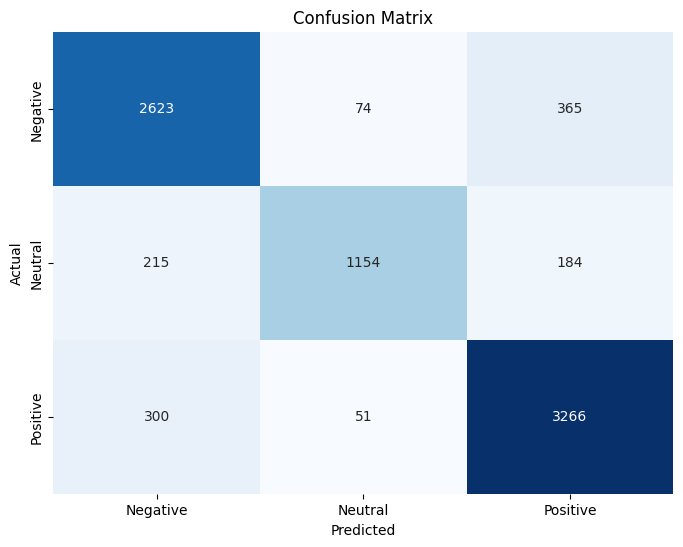

In [45]:
# Predict
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
# Classification Report
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      3062
           1       0.90      0.74      0.81      1553
           2       0.86      0.90      0.88      3617

    accuracy                           0.86      8232
   macro avg       0.86      0.83      0.85      8232
weighted avg       0.86      0.86      0.85      8232

